In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
from sklearn.cluster import KMeans
%matplotlib inline

Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- EWJ (Japan)
- FXI (China Large-cap)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [2]:
root_dir = os.getcwd()

In [3]:
tickers = dict(
    SPY=dict(asset='equity'),
    EWJ=dict(asset='equity'),
    FXI=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond'),
    GLD=dict(asset='commodity'),
    UCO=dict(asset='commodity'),
    JO=dict(asset='commodity'),
    SGG=dict(asset='commodity'),
    PPLT=dict(asset='commodity'),
#     VXX=dict(asset='commodity'),
    UUP=dict(asset='fx'),
    FXE=dict(asset='fx'),
    FXB=dict(asset='fx'),
    FXY=dict(asset='fx'),
    CEW=dict(asset='fx'),
    BZF=dict(asset='fx'),
)

In [4]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    for ticker in tickers.keys():
        df = pd.read_csv(root_dir+'/data/{}.csv'.format(ticker))
        df = df.replace({'null': np.nan})
        df['Close'] = pd.to_numeric(df['Close'])
        df['ticker'] = ticker
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
        df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)
        df['vol'] = df['pct_change'].std()
        tickers[ticker]['vol'] = df['pct_change'].std()
        df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
        df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
        df['asset_type'] = tickers[ticker]['asset']
        out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    ticker_to_category = pd.DataFrame.from_dict(tickers, orient='index')
#     ticker_to_category['category'] = pd.cut(ticker_to_category['vol'], n_categories, labels=range(n_categories))
    km = KMeans(n_categories)
    ticker_to_category['category'] = km.fit_predict([[x] for x in ticker_to_category['vol'].values])
    combined['category'] = combined['ticker'].apply(lambda x: ticker_to_category.loc[x, 'category'])
    return out, combined
        

In [6]:
prices, combined = build_prices_dfs(tickers, 3)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()


In [7]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [8]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

In [9]:
combined.groupby('ticker').mean()[['vol', 'category_enc']].sort_values('vol')

,vol,category_enc
ticker,,
AGG,0.003143,0
LQD,0.005037,0
CEW,0.005288,0
UUP,0.005639,0
FXE,0.006283,0
FXB,0.006298,0
FXY,0.006887,0
EMB,0.007078,0
HYG,0.008003,0


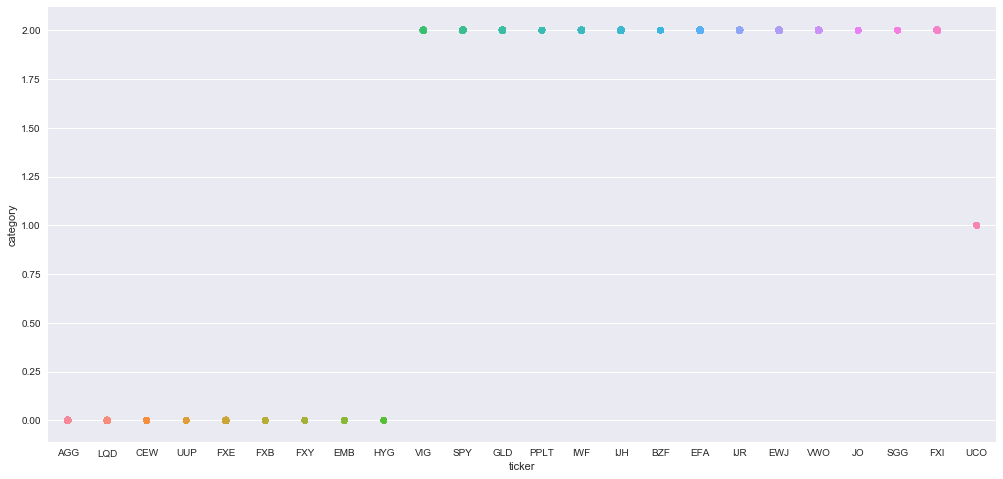

In [10]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined['vol']*1000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [11]:
combined = combined.dropna()

In [12]:
combined.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,vol,month_return,month_log_return,asset_type,category,category_enc,asset_type_enc,security_enc
Date,,,,,,,,,,,,,,,,,
2006-06-26,182.26,182.58,181.89,182.399994,163.659,24900,FXB,0.000110,0.000110,0.006298,0.021539,0.021210,fx,0,0,0,0
2006-06-27,182.35,182.78,182.35,182.419998,163.677,23400,FXB,-0.003234,-0.003240,0.006298,0.024703,0.024369,fx,0,0,0,0
2006-06-28,181.67,181.87,181.67,181.830002,163.148,125000,FXB,0.007590,0.007561,0.006298,0.030612,0.030280,fx,0,0,0,0
2006-06-29,181.2,183.21,181.17,183.210007,164.386,47600,FXB,0.009388,0.009344,0.006298,0.024570,0.024265,fx,0,0,0,0
2006-06-30,184.79,185.01,184.74,184.929993,165.929,31800,FXB,-0.004434,-0.004444,0.006298,0.015502,0.015240,fx,0,0,0,0


In [13]:
groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1])

In [14]:
prices, combined = build_prices_dfs(tickers, 3)

category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)
sec_category_map
n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

with pm.Model() as model:
    slow_window = 252 * 3
    for ticker in combined['ticker'].unique():
        combined.loc[combined['ticker'] == ticker, 'slow'] =\
        combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
    combined['value'] = pd.to_numeric((combined['Close'] - combined['slow']) / combined['slow'])
    combined = combined.dropna()
    
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
    a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
    a_sec_sd = pm.Uniform('a_security_sd', 1, 5)
    
    a_sec = pm.Normal('a_security', mu=a_category[sec_category_map], sd=a_sec_sd, shape=n_securities)
    
#     b_category_mu = pm.Normal('b_category_mu', mu=0, sd=1)
#     b_category_sd = pm.HalfCauchy('b_category_sd', 2)
    
#     b_category = pm.Normal('b_category', mu=b_category_mu, sd=b_category_sd, shape=n_categories)
#     b_sec_sd = pm.HalfCauchy('b_security_sd', 2)
#     b_nu = pm.Uniform('b_nu', 1, 20)
#     b_mu = pm.Normal('b_mu', mu=0, sd=2)
#     b_sd = pm.Uniform('b_sd', 1, 3)
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = (combined['value'].values * a_sec[combined['security_enc'].values] + b_sec[combined['security_enc'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=combined['month_log_return'].values)
    trace = pm.sample(1000, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,min_periods=22,center=False).sum()
100%|██████████| 1000/1000 [1:04:26<00:00,  1.20it/s]


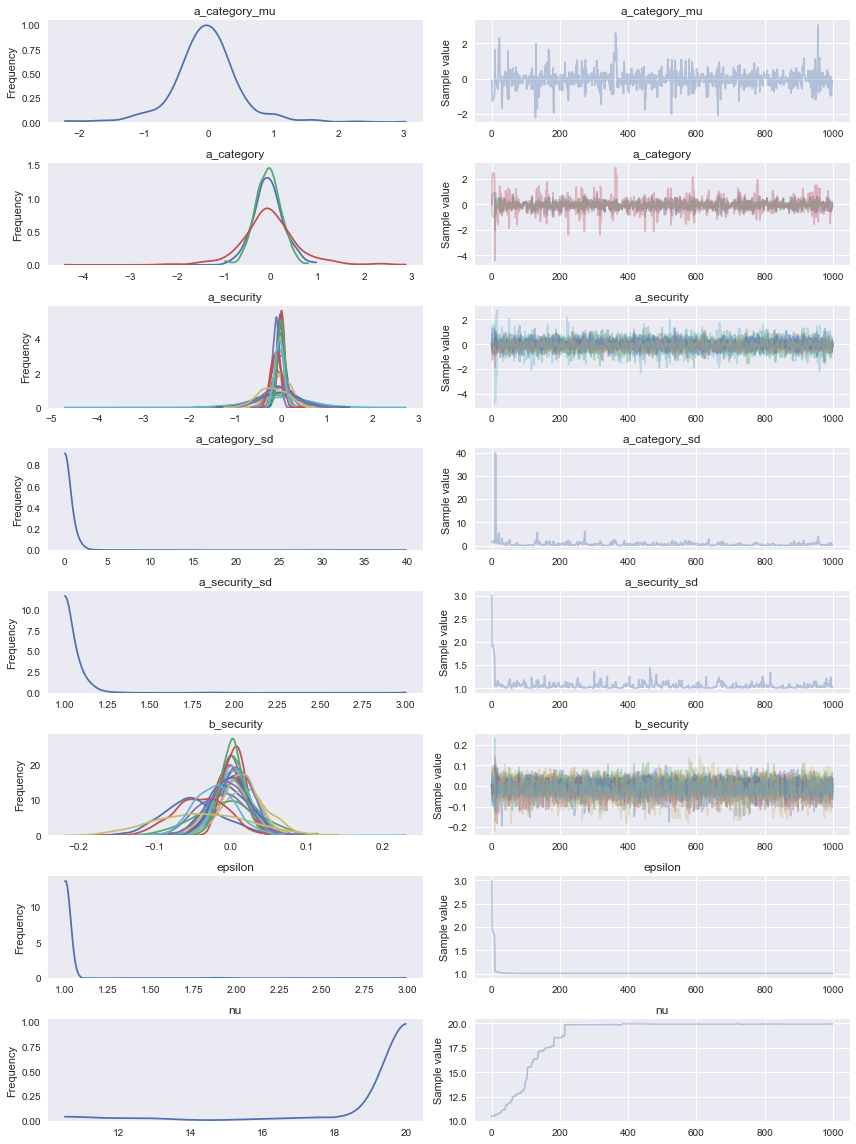

In [16]:
pm.traceplot(trace);

In [17]:
def calc_prediction_helper(row):
    rt = row.value * np.mean(trace['a_security'][:, row.security_enc])
#     print("{} = {} * {} + {}".format(rt, row.momentum,
#                                      np.mean(trace['a_security'][:, row.security_enc]),
#                                     np.mean(trace['b_security'][:, row.security_enc])))
    a = (row.value * trace['a_security'][:, row.security_enc] + trace['b_security'][:, row.security_enc])
    return np.mean(a > 0)

In [18]:
combined['prediction'] = combined.apply(calc_prediction_helper, axis=1)

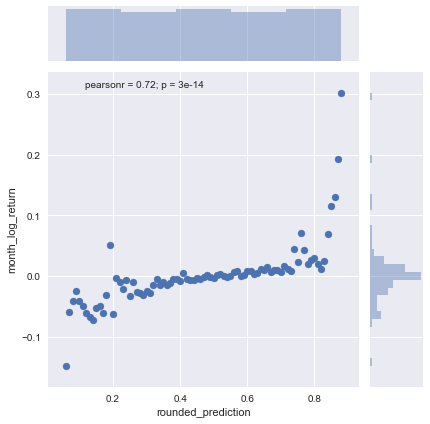

In [19]:
combined['rounded_prediction'] = combined['prediction'].round(2)
sns.jointplot(combined.groupby('rounded_prediction').mean()['month_log_return'].index, combined.groupby('rounded_prediction').mean()['month_log_return'])

In [24]:
print('Avg. return on long positions: {}'.format(combined.loc[combined.prediction >= .55, 'month_log_return'].mean()))
print('Avg. return on short positions: {}'.format(combined.loc[combined.prediction < .45, 'month_log_return'].mean()))

Avg. return on long positions: 0.00873968402617684
Avg. return on short positions: -0.018747022952049972


In [21]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = trace['a_security'][:, i]
    ticker_to_b[t] = trace['b_security'][:, i]

In [22]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(FXB=[-0.0356481929316, -0.0356481929316, -0.239033072018, -0.286057965939, -0.177097495865, -0.174945084602, -0.0558182341592, -0.0707621926177, 0.0472323397725, -0.0376839822301, 0.513578121827, -0.59569149561, -0.431956956957, 0.396314305922, -0.64932136588, -0.64932136588, 0.832385280264, 0.217262592257, 0.220884788598, -0.338955297678, 0.277251687355, 0.102980983427, 0.121758495399, 0.121758495399, 0.332922870649, -0.425437040696, 0.318947831538, -0.200882797671, 0.130732671682, 0.0390942980912, -0.0312615417056, 0.164450767573, -0.315317284298, -0.315317284298, -0.0167708974431, 0.311768829927, 0.00598803934083, 0.0603397307808, 0.0603397307808, 0.174294327562, -0.00753017723394, 0.0399426278568, 0.278330518548, 0.278330518548, -0.384463273806, 0.145928430563, -0.255608359058, 0.212043497238, 0.257211610035, -0.170297701858, 0.24673873009, -0.111575269591, -0.00542645098259, 0.212559145017, 0.130946304588, 0.041038378984, 0.172036474282, 0.172036474282, -0.248888594795, -0.32

In [23]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(FXB=[-0.00539297592067, -0.00539297592067, -0.0263114711475, -0.0182077126264, -0.0362188368728, -0.0333138739202, -0.0307642666274, -0.0313814662153, -0.0185910989973, 0.0213528868094, -0.0590322684211, 0.0479371538097, 0.0449045639378, -0.0532814931482, 0.0248259683346, 0.0248259683346, 0.00862836781682, 0.0368876589474, 0.0271760359853, -0.0466547671214, 0.0119422686973, 0.00760663371665, 0.0365003714668, 0.0365003714668, -0.0181101949966, 0.0285329686407, -0.00261696637434, -0.00101534542826, -0.00862492976165, 0.0176753906114, -0.0178918530025, 0.0305909935716, -0.0194139083749, -0.0194139083749, -0.00748776773613, -0.00946112569656, 0.0372544900965, -0.0287292908421, -0.0287292908421, -0.00965281626642, -0.00631704182237, -0.00234013945056, 0.0276337613506, 0.0276337613506, -0.0189027492599, -0.00112893487538, 0.0364925572522, -0.0327109755464, -0.0169885964082, -0.00778341600895, 0.00898538672883, -0.00959768078395, -0.0161760719106, 0.0194671899437, 0.0131099802521, -0.013

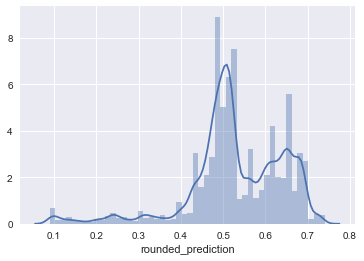

In [450]:
sns.distplot(combined['rounded_prediction'])
# sns.distplot(combined['month_log_return'])

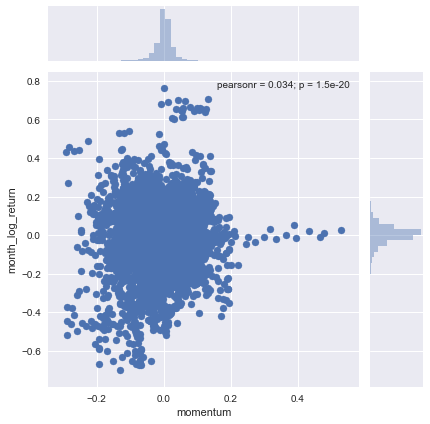

In [451]:
sns.jointplot('momentum', 'month_log_return', data=combined)

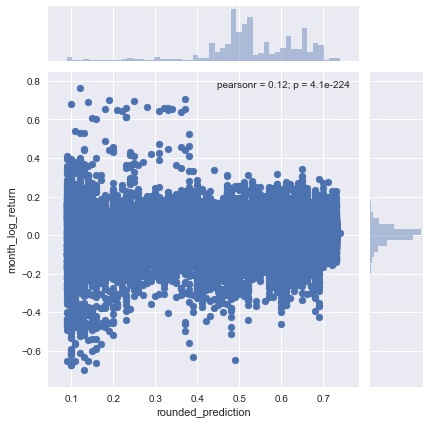

In [452]:
sns.jointplot('rounded_prediction', 'month_log_return', data=combined)

In [1]:
combined['position'] = 0
combined['position'] = np.where(combined['prediction'] >= .5, 1, 0)
combined['position'] = np.where(combined['prediction'] < .5, -1, 0)
combined['bt_return'] = combined['log_return'] * combined['position']
combined['date'] = combined.index

NameError: name 'combined' is not defined

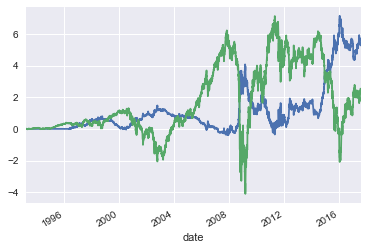

In [454]:
combined.groupby('date').sum()['bt_return'].cumsum().plot()
combined.groupby('date').sum()['log_return'].cumsum().plot()

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

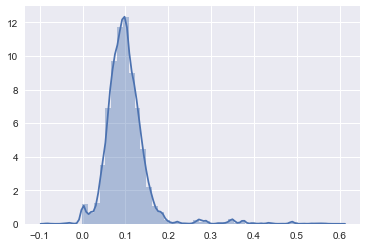

In [319]:
sns.distplot(trace['a_security'][:, 10])

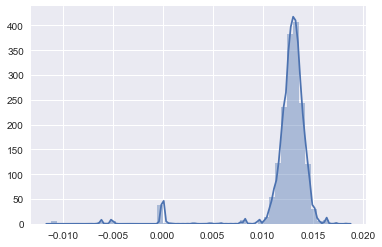

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
